<a href="https://colab.research.google.com/github/Crawnicles/Algo-trading-project/blob/main/SPX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction
"Williams %R, also known as the Williams Percent Range, is a type of momentum indicator that moves between 0 and -100 and measures overbought and oversold levels. The Williams %R may be used to find entry and exit points in the market. The indicator is very similar to the Stochastic oscillator and is used in the same way. It was developed by Larry Williams and it compares a stock’s closing price to the high-low range over a specific period, typically 14 days or periods."
-https://www.investopedia.com/terms/w/williamsr.asp

In [12]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
from math import floor
from termcolor import colored as cl

plt.rcParams['figure.figsize'] = (20,10)
plt.style.use('fivethirtyeight')

In [13]:
## Define a function to build a dataframe to get historical data using the ticker
def get_historical_data(symbol, start_date):
    api_key = '627b5accb1ab483e8715d46a6f460e85'
    api_url = f'https://api.twelvedata.com/time_series?symbol={symbol}&interval=1day&outputsize=5000&apikey={api_key}'
    raw_df = requests.get(api_url).json()
    df = pd.DataFrame(raw_df['values']).iloc[::-1].set_index('datetime').astype(float)
    df = df[df.index >= start_date]
    df.index = pd.to_datetime(df.index)
    return df
'''
# Instead of setting spx up and doing each stock seperate, loop through a list
to get the stock data

stocks = ['SPX', 'TSLA', 'META', 'VIX']

for s in stocks 
  stock = get_historical_data([stocks],'2020-01-01')

'''

spx = get_historical_data('SPX', '2020-01-01')
print(spx)

                  open        high         low       close        volume
datetime                                                                
2020-01-02  3244.66992  3258.13989  3235.53003  3257.85010  0.000000e+00
2020-01-03  3226.36011  3246.14990  3222.34009  3234.85010  0.000000e+00
2020-01-06  3217.55005  3246.84009  3214.63989  3246.28003  0.000000e+00
2020-01-07  3241.86011  3244.90991  3232.42993  3237.17993  0.000000e+00
2020-01-08  3238.59009  3267.07007  3236.66992  3253.05005  0.000000e+00
...                ...         ...         ...         ...           ...
2022-02-17  4456.06006  4456.06006  4373.81006  4380.04980  2.531020e+09
2022-02-18  4384.56982  4394.60010  4327.22021  4348.66992  2.587447e+09
2022-02-22  4332.74023  4362.12012  4267.10986  4304.75977  2.750082e+09
2022-02-23  4324.93018  4341.50977  4221.50977  4225.50000  2.513916e+09
2022-02-24  4155.77002  4294.72998  4114.64990  4288.70020  3.556528e+09

[542 rows x 5 columns]


In [14]:
# Define a function to provide historical data relevant to the model (Open, High, Low, Close, Volume)
# wr_14 = 14-day Williams %R of the stock
# hhigh = 14-day Highest High of the stock
# llow = 14-day Lowest Low of the stock
# close = Most recent close price
def get_wr(high, low, close, lookback):
    highh = high.rolling(lookback).max() 
    lowl = low.rolling(lookback).min()
    wr = -100 * ((highh - close) / (highh - lowl))
    return wr

In [15]:
#
spx['wr_14'] = get_wr(spx['high'], spx['low'], spx['close'], 14)
spx = spx.dropna()
print(spx)

                  open        high  ...        volume      wr_14
datetime                            ...                         
2020-01-22  3330.02002  3337.77002  ...  0.000000e+00 -13.010642
2020-01-23  3315.77002  3326.87988  ...  0.000000e+00  -9.932565
2020-01-24  3333.10010  3333.17993  ...  0.000000e+00 -34.353939
2020-01-27  3247.15991  3258.85010  ...  0.000000e+00 -89.367818
2020-01-28  3255.35010  3285.78003  ...  0.000000e+00 -59.581697
...                ...         ...  ...           ...        ...
2022-02-17  4456.06006  4456.06006  ...  2.531020e+09 -93.400466
2022-02-18  4384.56982  4394.60010  ...  2.587447e+09 -91.999059
2022-02-22  4332.74023  4362.12012  ...  2.750082e+09 -88.528371
2022-02-23  4324.93018  4341.50977  ...  2.513916e+09 -98.917228
2022-02-24  4155.77002  4294.72998  ...  3.556528e+09 -63.387113

[529 rows x 6 columns]


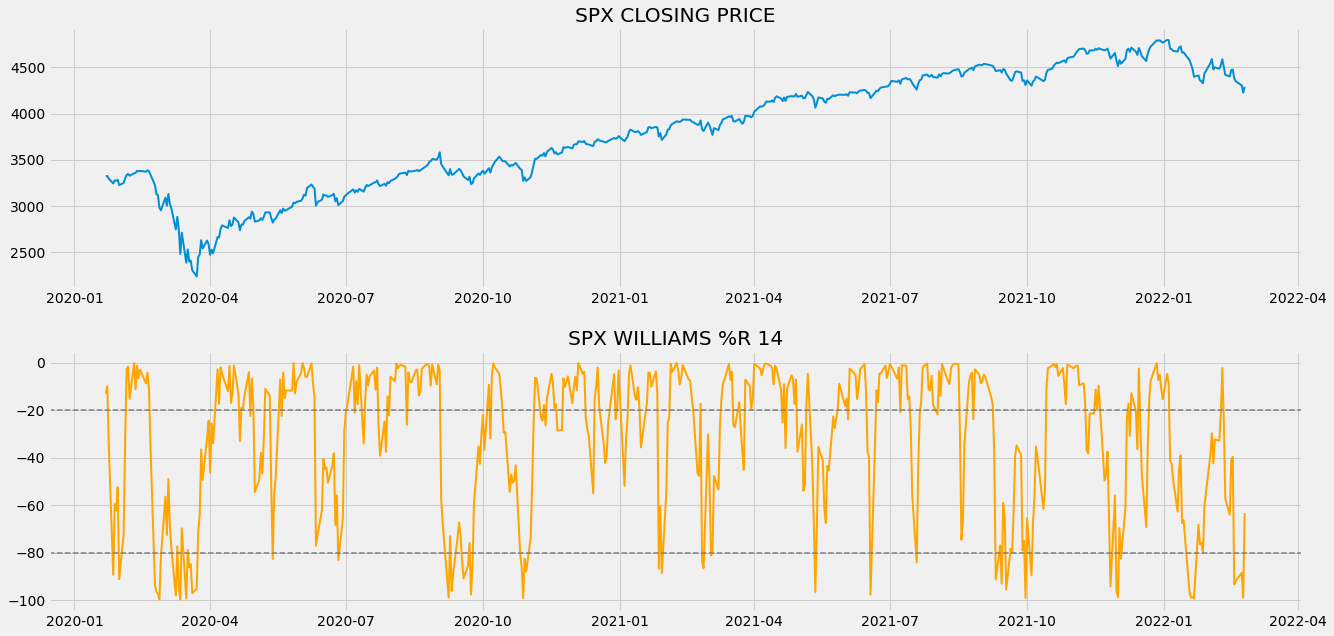

In [16]:
# Plot the SPX 
ax1 = plt.subplot2grid((11,1), (0,0), rowspan = 5, colspan = 1)
ax1.plot(spx['close'], linewidth = 2)
ax1.set_title('SPX CLOSING PRICE')

# Plot the Williams %R
ax2 = plt.subplot2grid((11,1), (6,0), rowspan = 5, colspan = 1)
ax2.plot(spx['wr_14'], color = 'orange', linewidth = 2)
ax2.axhline(-20, linewidth = 1.5, linestyle = '--', color = 'grey')
ax2.axhline(-80, linewidth = 1.5, linestyle = '--', color = 'grey')
ax2.set_title('SPX WILLIAMS %R 14')

# Display the plots
plt.show()

In [17]:
'''
Define a function to implement the strategy:

if the previous wr (i-1) is greater than -80 and
the current wr (i) is less than -80 BUY,

if the previous wr (i-1) is les than -20 and
the current wr (i) is greater than -20 SELL
'''

def implement_wr_strategy(prices, wr):    
    buy_price = []
    sell_price = []
    wr_signal = []
    signal = 0

    for i in range(len(wr)):
        if wr[i-1] > -80 and wr[i] < -80:
            if signal != 1:
                buy_price.append(prices[i])
                sell_price.append(np.nan)
                signal = 1
                wr_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                wr_signal.append(0)
        elif wr[i-1] < -20 and wr[i] > -20:
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(prices[i])
                signal = -1
                wr_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                wr_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            wr_signal.append(0)
            
    return buy_price, sell_price, wr_signal
            
buy_price, sell_price, wr_signal = implement_wr_strategy(spx['close'], spx['wr_14'])

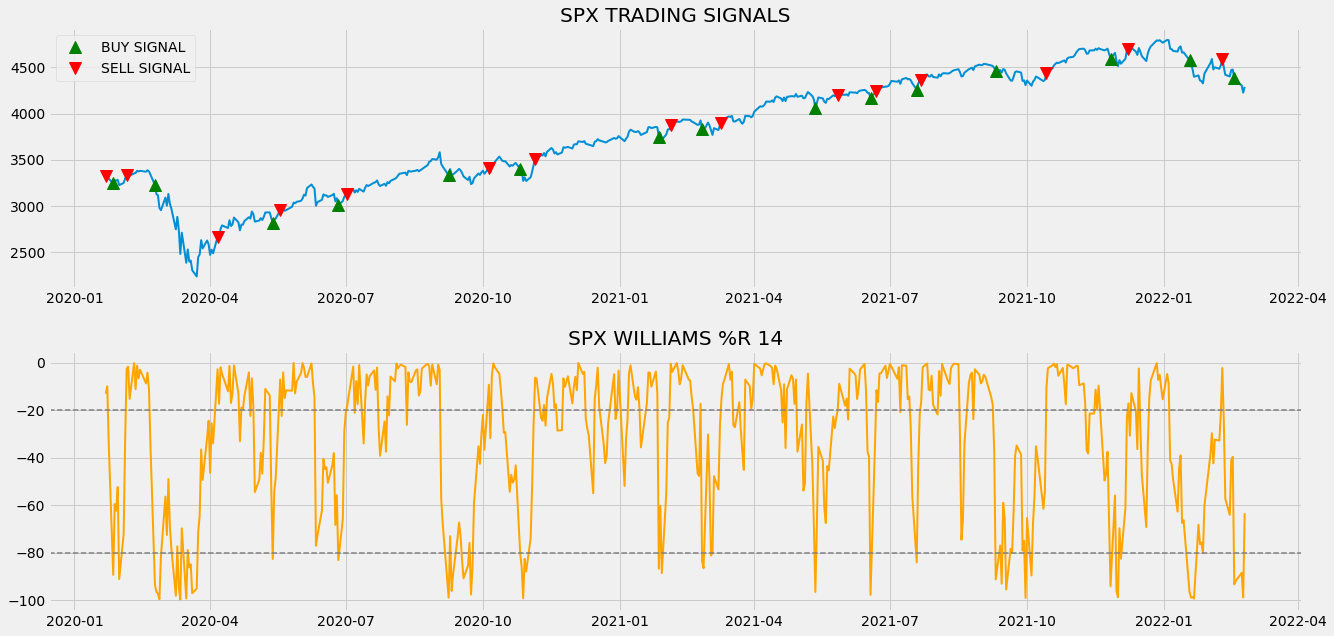

In [18]:
# Plot the buy and sell signals for the SPX using wr
ax1 = plt.subplot2grid((11,1), (0,0), rowspan = 5, colspan = 1)
ax1.plot(spx['close'], linewidth = 2)
ax1.plot(spx.index, buy_price, marker = '^', markersize = 12, linewidth = 0, color = 'green', label = 'BUY SIGNAL')
ax1.plot(spx.index, sell_price, marker = 'v', markersize = 12, linewidth = 0, color = 'r', label = 'SELL SIGNAL')
ax1.legend()
ax1.set_title('SPX TRADING SIGNALS')

# Plot the Williams %R
ax2 = plt.subplot2grid((11,1), (6,0), rowspan = 5, colspan = 1)
ax2.plot(spx['wr_14'], color = 'orange', linewidth = 2)
ax2.axhline(-20, linewidth = 1.5, linestyle = '--', color = 'grey')
ax2.axhline(-80, linewidth = 1.5, linestyle = '--', color = 'grey')
ax2.set_title('SPX WILLIAMS %R 14')

# Display the plots
plt.show()

In [19]:
# Create a list that indicates 1 if we hold the stock or 0 if not

position = []
for i in range(len(wr_signal)):
    if wr_signal[i] > 1:
        position.append(0)
    else:
        position.append(1)
        
for i in range(len(spx['close'])):
    if wr_signal[i] == 1:
        position[i] = 1
    elif wr_signal[i] == -1:
        position[i] = 0
    else:
        position[i] = position[i-1]
        
close_price = spx['close']
wr = spx['wr_14']
wr_signal = pd.DataFrame(wr_signal).rename(columns = {0:'wr_signal'}).set_index(spx.index)
position = pd.DataFrame(position).rename(columns = {0:'wr_position'}).set_index(spx.index)

frames = [close_price, wr, wr_signal, position]
strategy = pd.concat(frames, join = 'inner', axis = 1)

print(strategy)

                 close      wr_14  wr_signal  wr_position
datetime                                                 
2020-01-22  3321.75000 -13.010642         -1            0
2020-01-23  3325.54004  -9.932565          0            0
2020-01-24  3295.46997 -34.353939          0            0
2020-01-27  3243.62988 -89.367818          1            1
2020-01-28  3276.23999 -59.581697          0            1
...                ...        ...        ...          ...
2022-02-17  4380.04980 -93.400466          1            1
2022-02-18  4348.66992 -91.999059          0            1
2022-02-22  4304.75977 -88.528371          0            1
2022-02-23  4225.50000 -98.917228          0            1
2022-02-24  4288.70020 -63.387113          0            1

[529 rows x 4 columns]


In [20]:
# Calculate the returns using the model
spx_ret = pd.DataFrame(np.diff(spx['close'])).rename(columns = {0:'returns'})
wr_strategy_ret = []

for i in range(len(spx_ret)):
    returns = spx_ret['returns'][i]*strategy['wr_position'][i]
    wr_strategy_ret.append(returns)
    
wr_strategy_ret_df = pd.DataFrame(wr_strategy_ret).rename(columns = {0:'wr_returns'})
investment_value = 5000
number_of_stocks = floor(investment_value/spx['close'][-1])
wr_investment_ret = []

for i in range(len(wr_strategy_ret_df['wr_returns'])):
    returns = number_of_stocks*wr_strategy_ret_df['wr_returns'][i]
    wr_investment_ret.append(returns)

wr_investment_ret_df = pd.DataFrame(wr_investment_ret).rename(columns = {0:'investment_returns'})
total_investment_ret = round(sum(wr_investment_ret_df['investment_returns']), 2)
profit_percentage = floor((total_investment_ret/investment_value)*100)
print(cl('Profit gained from the W%R strategy by investing $100k in SPX : {}'.format(total_investment_ret), attrs = ['bold']))
print(cl('Profit percentage of the W%R strategy : {}%'.format(profit_percentage), attrs = ['bold']))


Profit gained from the W%R strategy by investing $100k in SPX : 492.07
Profit percentage of the W%R strategy : 9%


In [21]:
# Define a benchmark
def get_benchmark(start_date, investment_value):
    spy = get_historical_data('SPY', start_date)['close']
    benchmark = pd.DataFrame(np.diff(spy)).rename(columns = {0:'benchmark_returns'})
    
    investment_value = investment_value
    number_of_stocks = floor(investment_value/spy[-1])
    benchmark_investment_ret = []
    
    for i in range(len(benchmark['benchmark_returns'])):
        returns = number_of_stocks*benchmark['benchmark_returns'][i]
        benchmark_investment_ret.append(returns)

    benchmark_investment_ret_df = pd.DataFrame(benchmark_investment_ret).rename(columns = {0:'investment_returns'})
    return benchmark_investment_ret_df

benchmark = get_benchmark('2020-01-01', 5000)

investment_value = 5000
total_benchmark_investment_ret = round(sum(benchmark['investment_returns']), 2)
benchmark_profit_percentage = floor((total_benchmark_investment_ret/investment_value)*100)
print(cl('Benchmark profit by investing $5k : {}'.format(total_benchmark_investment_ret), attrs = ['bold']))
print(cl('Benchmark Profit percentage : {}%'.format(benchmark_profit_percentage), attrs = ['bold']))
print(cl('W%R Strategy profit is {}% higher than the Benchmark Profit'.format(profit_percentage - benchmark_profit_percentage), attrs = ['bold']))


Benchmark profit by investing $5k : 1030.85
Benchmark Profit percentage : 20%
W%R Strategy profit is -11% higher than the Benchmark Profit
